# Backward prediction to meet multiple targets

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, ConstantKernel, WhiteKernel

# Cross validation
from sklearn.model_selection import (KFold, ShuffleSplit)
from sklearn.metrics import mean_squared_error, r2_score

#GPy
import GPy, GPyOpt

#Pickle
import pickle

Populating the interactive namespace from numpy and matplotlib


### Load prediction models

In [2]:
with open('best_gaussr_sklearn.pickle', mode='rb') as f:
    best_gaussr_sklearn = pickle.load(f)

### Load generated random samples

In [3]:
df_bf      = pd.read_csv('generated_samples_brute_force.csv')
df_GMM_adj = pd.read_csv('generated_samples_GMM_adj.csv')

In [4]:
print(df_bf.shape)
df_bf.head()

(1000, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.784331,4.450274,2.284880,72.685554,1.864189,9.232008,2.151671,0.471711
1,13.162493,1.794175,3.072468,74.357421,0.226147,6.174670,2.056377,0.236789
2,13.821108,4.287679,0.756181,72.516608,1.546282,8.259448,0.167286,0.258803
3,16.387456,0.298935,3.255674,74.254107,1.345867,6.445369,0.231204,0.185021
4,17.209106,1.887915,0.601485,73.484072,0.190866,9.086538,0.420682,0.443250


In [5]:
print(df_GMM_adj.shape)
df_GMM_adj.head()

(1004, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.125720,3.136808,1.435357,72.816294,0.200172,8.644569,0.225666,0.415414
1,12.940038,3.607249,1.682601,72.486700,0.517273,8.514089,0.000000,0.252051
2,12.645276,3.113014,1.708007,72.445811,0.531375,9.206332,0.053386,0.296801
3,12.824230,3.317088,1.662362,72.445141,0.421705,9.069278,0.071913,0.188282
4,12.707278,2.839229,2.426215,72.706137,0.637424,8.464941,0.180141,0.038636


### Perfrom backward prediction

In [6]:
y_bf        = best_gaussr_sklearn.predict(np.array(df_bf)).reshape(-1,1)
y_GMM_adj = best_gaussr_sklearn.predict(np.array(df_GMM_adj)).reshape(-1,1)

In [7]:
nbins = 50

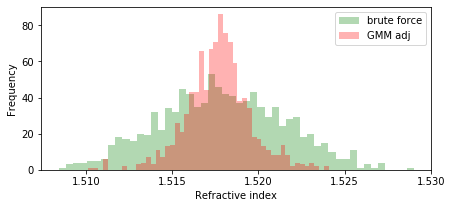

In [8]:
# See prediction results by new samples
plt.figure(figsize = (7, 3))
plt.hist(y_bf, bins = nbins, color = 'g', alpha = 0.3, label = 'brute force')
plt.hist(y_GMM_adj, bins = nbins, color = 'r', alpha = 0.3, label = 'GMM adj')
plt.xlabel('Refractive index')
plt.ylabel('Frequency')
plt.legend(loc = 'best')
plt.show()

### Merge brute force and GMM samples and prediction results

In [9]:
# Add prediction information
df_bf['group'] = 'BF'
df_bf['pred_RI'] = y_bf
df_GMM_adj['group'] = 'GMM'
df_GMM_adj['pred_RI'] = y_GMM_adj

In [10]:
# Merge brute force and GMM datasets
all_results = pd.concat([df_bf, df_GMM_adj])
print(all_results.shape)
all_results.head()

(2004, 10)


,Na,Mg,Al,Si,K,Ca,Ba,Fe,group,pred_RI
0,13.784331,4.450274,2.284880,72.685554,1.864189,9.232008,2.151671,0.471711,BF,1.523402
1,13.162493,1.794175,3.072468,74.357421,0.226147,6.174670,2.056377,0.236789,BF,1.512160
2,13.821108,4.287679,0.756181,72.516608,1.546282,8.259448,0.167286,0.258803,BF,1.519343
3,16.387456,0.298935,3.255674,74.254107,1.345867,6.445369,0.231204,0.185021,BF,1.509494
4,17.209106,1.887915,0.601485,73.484072,0.190866,9.086538,0.420682,0.443250,BF,1.519752


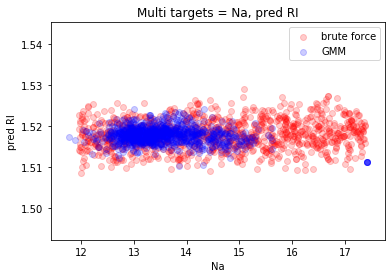

In [11]:
# Plot merged data to see if solution exists
plt.scatter(df_bf['Na'], df_bf['pred_RI'], c = 'r', alpha = 0.2, label = 'brute force')
plt.scatter(df_GMM_adj['Na'], df_GMM_adj['pred_RI'], c = 'b', alpha = 0.2, label = 'GMM')
plt.title('Multi targets = Na, pred RI')
plt.xlabel('Na')
plt.ylabel('pred RI')
plt.legend(loc = 'best')
plt.show()

### Screening by multiple targets

In [12]:
# Remove pred_RI > 1.514 and pred_Dk < 1.512
all_results = all_results[all_results['pred_RI'] < 1.514]
all_results = all_results[all_results['pred_RI'] > 1.512]

In [13]:
all_results.shape

(111, 10)

In [14]:
# Remove Na > 15 and Na < 14
all_results = all_results[all_results['Na'] < 15.0]
all_results = all_results[all_results['Na'] > 14.0]

In [15]:
print(all_results.shape)
all_results

(26, 10)


,Na,Mg,Al,Si,K,Ca,Ba,Fe,group,pred_RI
80,14.765831,1.668241,1.083938,74.684875,1.677025,7.257033,0.382534,0.086622,BF,1.513783
164,14.985316,2.342987,1.820893,74.065273,0.466968,5.897009,1.174025,0.127916,BF,1.512592
223,14.034670,4.237012,3.169002,72.751814,0.320834,6.150448,0.781151,0.496267,BF,1.513263
356,14.647098,1.259829,0.466453,73.979155,0.664098,5.976605,1.007557,0.061387,BF,1.513068
386,14.887649,0.319414,3.229494,73.006455,0.287994,7.598473,0.608493,0.367143,BF,1.512973
406,14.878141,1.249782,1.259255,72.929130,1.820690,5.577444,0.988600,0.010645,BF,1.512749
488,14.509043,4.070026,3.473703,75.157330,1.560175,5.868394,2.468634,0.322739,BF,1.513562
504,14.222487,2.452116,3.060411,71.957834,0.912377,5.914529,0.514338,0.365878,BF,1.512058
639,14.227038,2.760411,2.203312,71.256020,2.431913,6.150601,0.058605,0.318841,BF,1.513831
651,14.059241,2.788866,2.155596,73.970043,0.366401,7.355379,0.255561,0.008984,BF,1.513580


In [16]:
all_results.to_csv('final_screened_results.csv', index = None)

### Plot candidate composition clusters

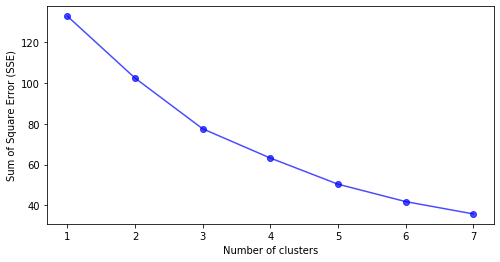

In [17]:
from sklearn.cluster import KMeans
sse = list()

for i  in range(1,len(all_results.columns.values)-2):                                                       # test upto 15 clusters 
    km = KMeans(n_clusters=i, random_state=1).fit(all_results.iloc[:, 0:8])
    sse.append(km.inertia_)                                                  # .inertia_ means sum of square error

plt.figure(figsize=(8, 4))
plt.plot(range(1,len(all_results.columns.values)-2), sse, c='b', marker='o', alpha = 0.7)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Square Error (SSE)')
plt.show()

In [18]:
##### Input numbers of clusters you want (max = 10 due to color constraint in the plots)
num = input('Input number of composition groups you want to test : ')

Input number of composition groups you want to test : 3


In [19]:
kmeans_model = KMeans(n_clusters=int(num), random_state=1).fit(all_results.iloc[:, 0:8])

#get labels
labels = kmeans_model.labels_
print('labels = ', labels)

labels =  [0 1 1 2 0 2 1 1 1 0 0 1 0 1 1 0 2 1 0 0 0 2 2 2 1 2]


In [20]:
# Add culumn 'CLS_label' as clustering label
all_results['CLS_label'] = labels
all_results.head()

,Na,Mg,Al,Si,K,Ca,Ba,Fe,group,pred_RI,CLS_label
80,14.765831,1.668241,1.083938,74.684875,1.677025,7.257033,0.382534,0.086622,BF,1.513783,0
164,14.985316,2.342987,1.820893,74.065273,0.466968,5.897009,1.174025,0.127916,BF,1.512592,1
223,14.034670,4.237012,3.169002,72.751814,0.320834,6.150448,0.781151,0.496267,BF,1.513263,1
356,14.647098,1.259829,0.466453,73.979155,0.664098,5.976605,1.007557,0.061387,BF,1.513068,2
386,14.887649,0.319414,3.229494,73.006455,0.287994,7.598473,0.608493,0.367143,BF,1.512973,0


In [21]:
df_centroids = pd.DataFrame(kmeans_model.cluster_centers_)
df_centroids.columns = list(all_results.columns[0:8])
df_centroids.head(int(num))

,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,14.505813,1.420459,2.505377,73.987679,0.738040,7.633116,0.481069,0.089663
1,14.429956,3.021497,2.552748,72.870233,1.025209,5.936079,0.952358,0.250987
2,14.670630,0.918062,1.852873,72.852283,1.254669,5.784108,1.512213,0.053279


In [22]:
# Color codes for scatter plots 
color_codes = {0:'red',
               1:'green',
               2:'blue',
               3:'yellow',
               4:'magenta',
               5:'cyan',
               6:'black',
               7:'brown',
               8:'orange',
               9:'pink'}

colors = list()
for i in range(len(labels)) :
    colors.append(color_codes[labels[i]])

sample hit =      o: BF, ^: GMM, x: centroid


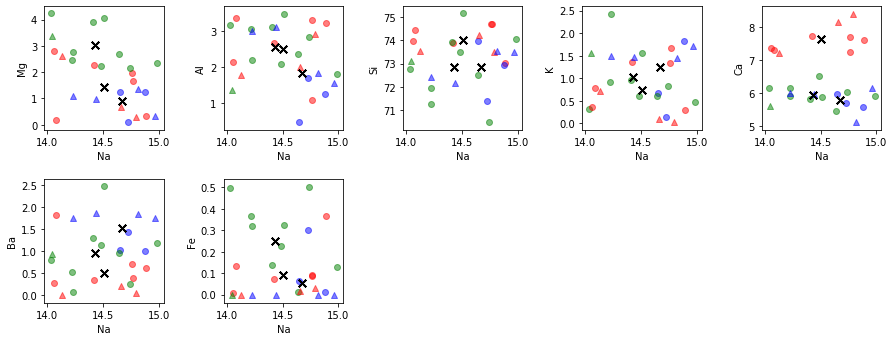

In [23]:
# Draw scatter plots element vs. performance in colors of clusters
horz = 5                     # vertical number of graph
vert = 5                     # horizontal number of graph
graph_num = horz * vert      # maximum number of graphs
axes = list()

start = all_results.columns.get_loc('Na')
end   = all_results.columns.get_loc('group')

column_names = all_results.columns.values

fig = plt.figure(figsize=(15, 15))

for i in range(1, end - start):
    axes.append(fig.add_subplot(vert, horz, i))
    for j in range(len(all_results)) :
        x = all_results.iloc[j, start]
        y = all_results.iloc[j, start + i]
        if all_results.iloc[j, 8] == 'BF':
            axes[i-1].scatter(x, y, marker='o', c = colors[j], alpha = 0.5)
        else:
            axes[i-1].scatter(x, y, marker='^', c = colors[j], alpha = 0.5)
            
        axes[i-1].scatter(kmeans_model.cluster_centers_[:,start], kmeans_model.cluster_centers_[:,start+i], s = 50, marker='x', c='k')
    axes[i-1].set_xlabel(column_names[start], size = 10)
    axes[i-1].set_ylabel(column_names[start+i], size = 10)
    
plt.subplots_adjust(wspace=0.5, hspace=0.4)
print('sample hit =      o: BF, ^: GMM, x: centroid')
plt.show()